# Notebook 4: Classification using CNN

In this notebook, we will use a CNN model to classify the images.

---

### Necessaries packages

We will import the differents libraries used in this notebook.


In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import pickle

### Reading the data

We will load the saved image and label data from the NumPy files.

Also, we are going to split the training dataset in training and validation datasets
create a new validation set by splitting the original training data (80% for new training, 20% for new validation)


The code loads pre-existing training, validation, and test datasets (images and labels) from .npy files.

It prints the dimensions (shapes) of these initially loaded datasets.

It then disregards the initially loaded validation set and creates a new validation set by splitting the original training data (80% for new training, 20% for new validation), ensuring class proportions are maintained (stratify).

Finally, it prints the dimensions of these newly created training and validation sets, which will likely be used for the subsequent model training and evaluation during development. The original test set remains untouched for final evaluation.

In [7]:
# Load the datasets
train_images = np.load('data/train_images.npy')
train_labels = np.load('data/train_labels.npy')
val_images = np.load('data/val_images.npy')
val_labels = np.load('data/val_labels.npy')
test_images = np.load('data/test_images.npy')
test_labels = np.load('data/test_labels.npy')

# Print basic information about each dataset before splitting
print(f"Original Training images: {train_images.shape}, Training labels: {train_labels.shape}")
print(f"Original Validation images: {val_images.shape}, Validation labels: {val_labels.shape}")
print(f"Testing images: {test_images.shape}, Testing labels: {test_labels.shape}")

# Split the training data into new training and validation sets (80% train, 20% val)
train_images_new, val_images_new, train_labels_new, val_labels_new = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

# Print the shapes of the new splits
print(f"New Training images: {train_images_new.shape}, New Training labels: {train_labels_new.shape}")
print(f"New Validation images: {val_images_new.shape}, New Validation labels: {val_labels_new.shape}")

Original Training images: (9711, 512, 512, 3), Training labels: (9711,)
Original Validation images: (3237, 512, 512, 3), Validation labels: (3237,)
Testing images: (3237, 512, 512, 3), Testing labels: (3237,)
New Training images: (7768, 512, 512, 3), New Training labels: (7768,)
New Validation images: (1943, 512, 512, 3), New Validation labels: (1943,)


### Preprocessing 

The preprocessing consists of two differents functions :

The first function is applied on one image and f0llow these steps:

- Normalization: The image is converted to a tensor and normalized to a range between 0 and 1 by dividing by 255.0.
  
- Resizing: The image is resized to the target_size to reduce its dimensionality.

- Contrast Adjustment: The contrast of the image is enhanced using a factor of 1.5.

- Data Augmentation:
If the augment flag is True, apply the following transformations:
Random horizontal flipping.
Random vertical flipping.
Random brightness adjustment.
Random contrast adjustment within defined limits.

- Clipping: Values are clipped to ensure they remain within the range [0.0, 1.0].

- Flattening: The processed image is converted back to a NumPy array and flattened into a 1D array.




The second function applies this single-image preprocessing to an entire dataset by leveraging parallel processing with joblib, resulting in a standard feature matrix. 

- Parallel Processing: The function utilizes the Parallel and delayed functions from the joblib library to apply preprocess_image_for_ml to each image in the dataset concurrently.

- Feature Matrix Creation: The processed images are stacked into a feature matrix, where each row corresponds to a flattened, preprocessed image.

- Dataset Creation: Create a tf.data.Dataset from the images (and labels, if provided).

- Mapping Preprocessing: Apply the preprocess_image function to each image in the dataset. This is done using the map method, which can apply the function in parallel for efficiency.

- Batching: Group the images into batches of a specified size (batch_size).

- Prefetching: Use prefetching to optimize data loading, allowing the next batch to be prepared while the current batch is being processed.





In [8]:
# Preprocessing function with proper type casting
def preprocess_image(image, target_size=(128, 128), augment=False):
    """
    Preprocesses an image for training or prediction.
    
    Parameters:
    - image: Input image (tensor or numpy array)
    - target_size: Tuple of (height, width) to resize the image (default: 128x128)
    - augment: Boolean to apply data augmentation (default: False)
    
    Returns:
    - Preprocessed image
    """
    # Cast image to float32 and normalize to [0, 1] in one step
    img = tf.cast(image, tf.float32) / 255.0
    
    # Resize image to a smaller, uniform size
    img = tf.image.resize(img, target_size)
    
    # Apply basic contrast adjustment
    img = tf.image.adjust_contrast(img, contrast_factor=1.5)
    
    # Data augmentation (if enabled)
    if augment:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_brightness(img, max_delta=0.1)
        img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    
    # Clip values to ensure they stay in [0, 1]
    img = tf.clip_by_value(img, 0.0, 1.0)
    
    return img

# Function to preprocess the entire dataset
def preprocess_dataset(dataset, labels=None, target_size=(128, 128), augment=False, batch_size=16):
    """
    Applies preprocessing to an entire dataset.
    
    Parameters:
    - dataset: NumPy array of images
    - labels: NumPy array of labels (optional, for prediction set labels to None)
    - target_size: Tuple of (height, width) for resizing
    - augment: Boolean to apply data augmentation
    - batch_size: Batch size for the dataset
    
    Returns:
    - Preprocessed tf.data.Dataset
    """
    if labels is not None:
        # For training/validation with labels
        dataset = tf.data.Dataset.from_tensor_slices((dataset, labels))
        dataset = dataset.map(lambda x, y: (preprocess_image(x, target_size, augment), y),
                              num_parallel_calls=tf.data.AUTOTUNE)
    else:
        # For prediction without labels
        dataset = tf.data.Dataset.from_tensor_slices(dataset)
        dataset = dataset.map(lambda x: preprocess_image(x, target_size, augment),
                              num_parallel_calls=tf.data.AUTOTUNE)
    
    # Batch and prefetch for efficient training/prediction
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

- Label encoding: This part encodes categorical labels into numerical format, which is necessary for machine learning algorithms that require numerical input.
- Preprocessing Datasets with Parallelization : This section preprocesses the image datasets using a smaller target size (64x64 pixels) for reduced dimensionality and efficiency.

In [9]:
# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels_new)
val_labels_encoded = label_encoder.transform(val_labels_new)
valid_labels_encoded = label_encoder.transform(val_labels)

# Convert labels to one-hot encoding
num_classes = len(label_encoder.classes_)  # Should be 5
train_labels_onehot = to_categorical(train_labels_encoded, num_classes)
val_labels_onehot = to_categorical(val_labels_encoded, num_classes)
valid_labels_onehot = to_categorical(valid_labels_encoded, num_classes)



# Create tf.data.Dataset objects and apply preprocessing with batching
batch_size = 16
train_dataset = preprocess_dataset(train_images_new, train_labels_onehot, augment=True, batch_size=batch_size)
val_dataset = preprocess_dataset(val_images_new, val_labels_onehot, augment=False, batch_size=batch_size)
valid_dataset = preprocess_dataset(val_images, valid_labels_onehot, augment=False, batch_size=batch_size)

2025-04-17 09:30:37.567270: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6109003776 exceeds 10% of free system memory.
2025-04-17 09:30:46.058001: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1528037376 exceeds 10% of free system memory.
2025-04-17 09:30:50.366217: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2545680384 exceeds 10% of free system memory.


### Visualising the data after pre-processing

Shape of selected image: (512, 512, 3)


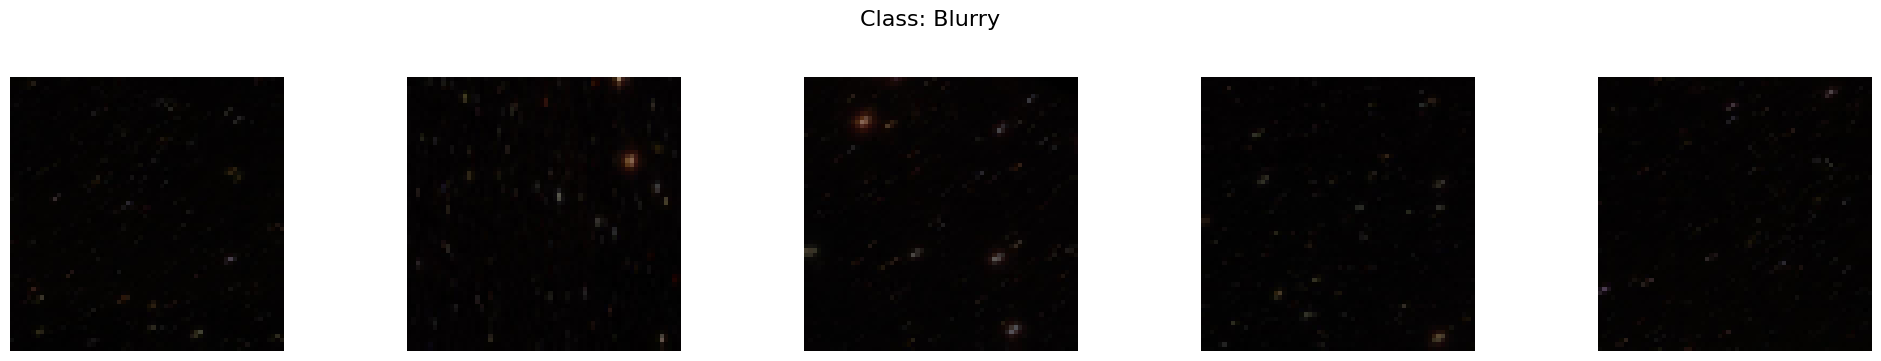


Shape of selected image: (512, 512, 3)


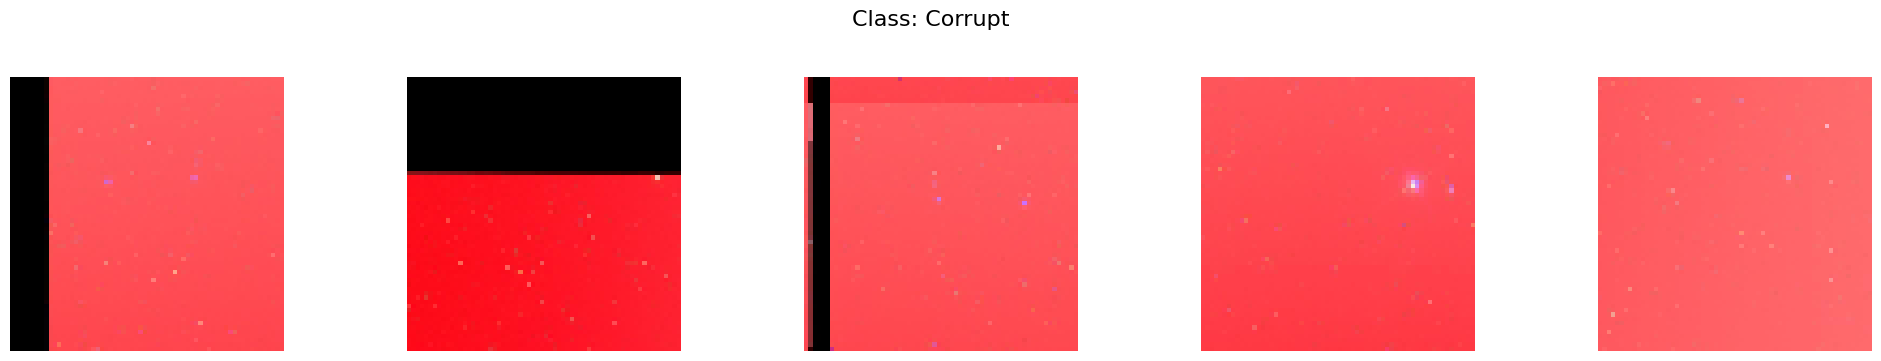


Shape of selected image: (512, 512, 3)


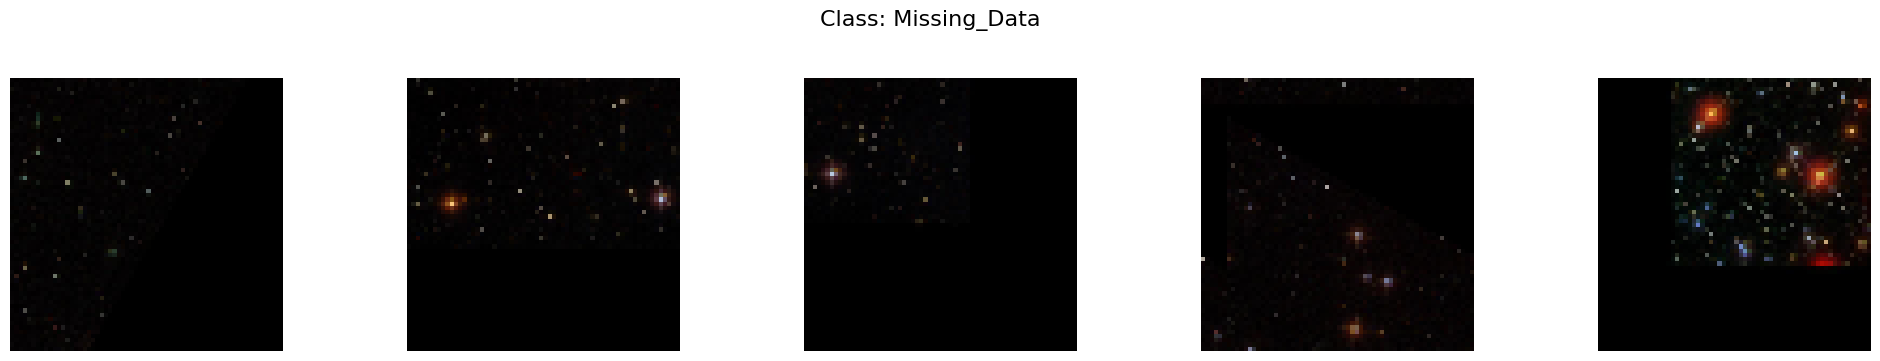


Shape of selected image: (512, 512, 3)


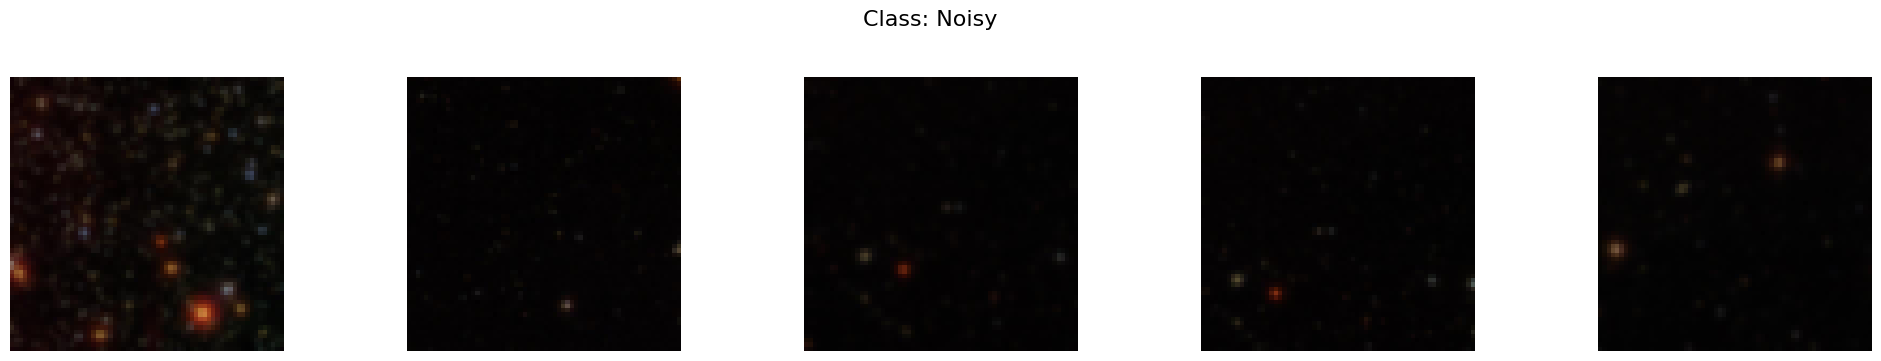


Shape of selected image: (512, 512, 3)


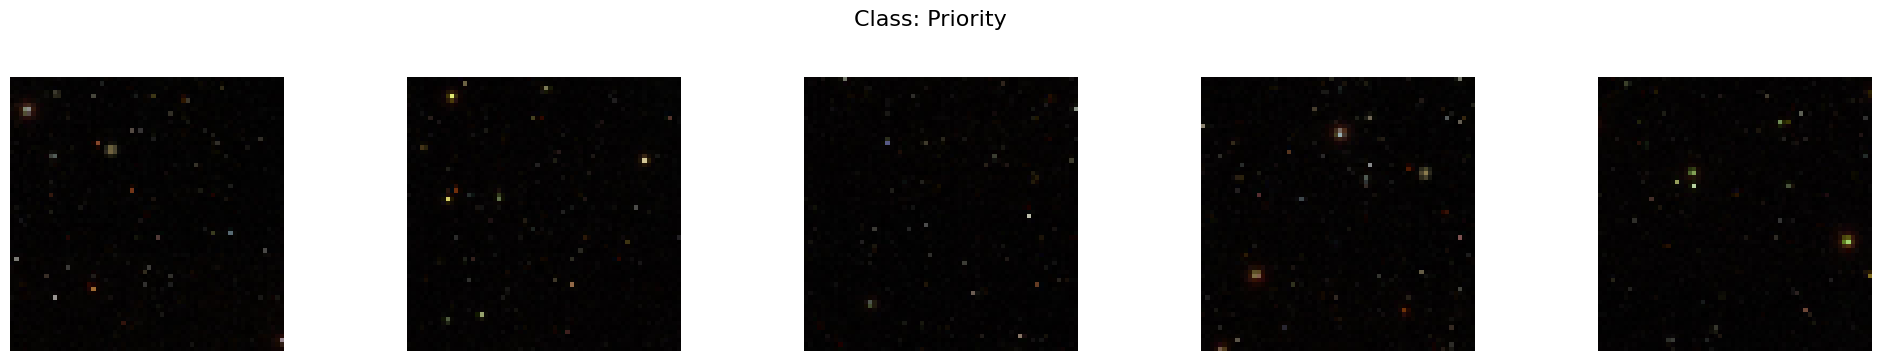

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import cv2  # Make sure to import OpenCV if you need resizing

# Define the class names
class_names = ["Blurry", "Corrupt", "Missing_Data", "Noisy", "Priority"]

# Get the unique labels in the training set
unique_labels = np.unique(train_labels_encoded)  # Use encoded labels

# Display the first 5 images for each class after preprocessing
for label in unique_labels:
    # Find the indices of images belonging to the current class
    class_indices = np.where(train_labels_encoded == label)[0]
    
    # Select the first 5 images of this class
    num_images_to_display = min(5, len(class_indices))
    selected_indices = class_indices[:num_images_to_display]
    selected_images = train_images_new[selected_indices]  # Use preprocessed images

    # Check the shape of the first image
    print(f"Shape of selected image: {selected_images[0].shape}")

    # Plot the selected images
    fig, axes = plt.subplots(1, num_images_to_display, figsize=(20, 4))
    fig.suptitle(f'Class: {class_names[label]}', fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    for i, ax in enumerate(axes):
        # Resize if necessary
        img_resized = cv2.resize(selected_images[i], (64, 64))  # Resize to 64x64
        ax.imshow(img_resized)
        ax.axis('off')
    
    plt.show()
    print()

### Train the CNN model

This architecture is efficient and adapted for image classification tasks due to its ability to extract relevant features, reduce dimensionality, and promote generalization. The combination of convolutional layers, pooling, dropout, and dense layers provides a solid foundation for recognizing patterns in images, making it suitable for a wide range of applications in computer vision.

In [11]:
%%time

# Build a simple CNN model
def build_cnn_model(input_shape=(128, 128, 3), num_classes=5):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Instantiate and compile the model
model = build_cnn_model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=10,
                    verbose=1)

/shared/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,285 (12.61 MB)

 Trainable params: 3,305,285 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


2025-04-17 09:30:58.205139: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6109003776 exceeds 10% of free system memory.


486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6831 - loss: 0.7923 

2025-04-17 09:31:47.715886: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1528037376 exceeds 10% of free system memory.


486/486 ━━━━━━━━━━━━━━━━━━━━ 53s 95ms/step - accuracy: 0.6834 - loss: 0.7917 - val_accuracy: 0.9665 - val_loss: 0.1414
Epoch 2/10
486/486 ━━━━━━━━━━━━━━━━━━━━ 41s 84ms/step - accuracy: 0.9508 - loss: 0.1668 - val_accuracy: 0.9820 - val_loss: 0.0717
Epoch 3/10
486/486 ━━━━━━━━━━━━━━━━━━━━ 43s 88ms/step - accuracy: 0.9654 - loss: 0.1087 - val_accuracy: 0.9964 - val_loss: 0.0198
Epoch 4/10
486/486 ━━━━━━━━━━━━━━━━━━━━ 43s 89ms/step - accuracy: 0.9737 - loss: 0.0826 - val_accuracy: 0.9979 - val_loss: 0.0109
Epoch 5/10
486/486 ━━━━━━━━━━━━━━━━━━━━ 45s 92ms/step - accuracy: 0.9806 - loss: 0.0617 - val_accuracy: 0.9990 - val_loss: 0.0054
Epoch 6/10
486/486 ━━━━━━━━━━━━━━━━━━━━ 81s 90ms/step - accuracy: 0.9859 - loss: 0.0450 - val_accuracy: 0.9990 - val_loss: 0.0050
Epoch 7/10
486/486 ━━━━━━━━━━━━━━━━━━━━ 45s 92ms/step - accuracy: 0.9883 - loss: 0.0352 - val_accuracy: 0.9979 - val_loss: 0.0071
Epoch 8/10
486/486 ━━━━━━━━━━━━━━━━━━━━ 41s 84ms/step - accuracy: 0.9834 - loss: 0.0657 - val_accurac

With the parallelization, we have a training time of 6 min 

In [12]:
# Save the model using pickle
with open('models/cnn_model.pkl', 'wb') as file:
    pickle.dump(model, file)
print("Model saved as 'cnn_model.pkl'")

Model saved as 'cnn_model.pkl'


In [13]:
with open('models/cnn_model.pkl', 'rb') as file:
    cnn_loaded_model = pickle.load(file)
    
#val_predictions = cnn_loaded_model.predict(val_images)

### Deep learning: Validation set results

In [14]:
# Evaluate the model on the test set
valid_loss, valid_accuracy = cnn_loaded_model.evaluate(valid_dataset, verbose=0)
print(f"Validation accuracy: {valid_accuracy:.4f}, Validation loss: {valid_loss:.4f}")

# Preprocess test images for prediction (without labels)
valid_dataset_for_prediction = preprocess_dataset(val_images, labels=None, augment=False, batch_size=batch_size)

# Make predictions on the test set
valid_predictions = cnn_loaded_model.predict(valid_dataset_for_prediction)

# Convert predictions and test labels from one-hot/probabilities to class indices
valid_predictions = np.argmax(valid_predictions, axis=1)
val_labels = np.argmax(valid_labels_onehot, axis=1)  # Convert one-hot test labels to indices

# Verify shapes for debugging
print(f"valid_predictions shape: {valid_predictions.shape}")
print(f"valid_labels shape: {val_labels.shape}")

# Detailed classification report
print("\nClassification Report for Test Set:")
print(classification_report(val_labels, valid_predictions, target_names=['Blurry', 'Corrupt', 'Missing_Data', 'Noisy', 'Priority']))


Validation accuracy: 0.9988, Validation loss: 0.0091
203/203 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
valid_predictions shape: (3237,)
valid_labels shape: (3237,)

Classification Report for Test Set:
              precision    recall  f1-score   support

      Blurry       1.00      1.00      1.00       727
     Corrupt       1.00      1.00      1.00       222
Missing_Data       1.00      1.00      1.00       421
       Noisy       1.00      1.00      1.00       721
    Priority       1.00      1.00      1.00      1146

    accuracy                           1.00      3237
   macro avg       1.00      1.00      1.00      3237
weighted avg       1.00      1.00      1.00      3237



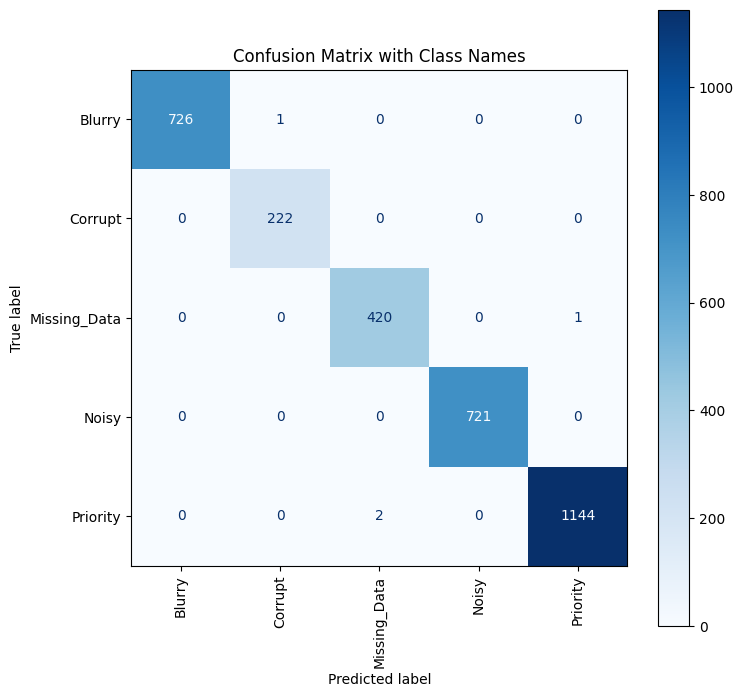

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define class names
class_names = ["Blurry", "Corrupt", "Missing_Data", "Noisy", "Priority"]

# Compute the confusion matrix
cm = confusion_matrix(val_labels, valid_predictions)

# Plot the confusion matrix with class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Customize and display the plot
fig, ax = plt.subplots(figsize=(8, 8))  # Set the figure size
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')  # Use a blue colormap
plt.title("Confusion Matrix with Class Names")
plt.show()

While the classification report rounds to perfect scores (1.00), the confusion matrix shows the model made only 4 errors on the 3237-sample test set. This translates to an extremely high actual accuracy of approximately 99.88%, which aligns perfectly with the final validation accuracy.

This is an outstanding result. The model demonstrates excellent discriminative power across all classes with negligible confusion between them. For virtually all practical applications, this level of performance would be considered highly successful. The consistency between the final validation accuracy and the test accuracy also indicates good generalization.

---

##### **⚠️ Freeing up Space**

In [17]:
import gc

# Remove the data from memory
del val_images, val_labels, train_images, train_labels

# Force garbage collection to free up memory
gc.collect()

# Clear the input/output cache
print("Data and models removed from memory.")

Data and models removed from memory.
